In [1]:
import re
import pandas as pd


### Preprocessing Functions

In [8]:
def cleaner(word):
    word = re.sub(r'\#\.', '', word)
    word = re.sub(r'\n', '', word)
    word = re.sub(r',', '', word)
    word = re.sub(r'\-', ' ', word)
    word = re.sub(r'\.', '', word)
    word = re.sub(r'\\', ' ', word)
    word = re.sub(r'\\x\.+', '', word)
    word = re.sub(r'\d', '', word)
    word = re.sub(r'^_.', '', word)
    word = re.sub(r'_', ' ', word)
    word = re.sub(r'^ ', '', word)
    word = re.sub(r' $', '', word)
    word = re.sub(r'\?', '', word)
    return word.lower()

# Define the hashing function
def hashing(word):
    word = re.sub(r'ain$', r'ein', word)
    word = re.sub(r'ai', r'ae', word)
    word = re.sub(r'ay$', r'e', word)
    word = re.sub(r'ey$', r'e', word)
    word = re.sub(r'ie$', r'y', word)
    word = re.sub(r'^es', r'is', word)
    word = re.sub(r'a+', r'a', word)
    word = re.sub(r'j+', r'j', word)
    word = re.sub(r'd+', r'd', word)
    word = re.sub(r'u', r'o', word)
    word = re.sub(r'o+', r'o', word)
    word = re.sub(r'ee+', r'i', word)
    if not re.match(r'ar', word):
        word = re.sub(r'ar', r'r', word)
    word = re.sub(r'iy+', r'i', word)
    word = re.sub(r'ih+', r'eh', word)
    word = re.sub(r's+', r's', word)
    if re.search(r'[rst]y', word) and word[-1] != 'y':
        word = re.sub(r'y', r'i', word)
    if re.search(r'[bcdefghijklmnopqrtuvwxyz]i', word):
        word = re.sub(r'i$', r'y', word)
    if re.search(r'[acefghijlmnoqrstuvwxyz]h', word):
        word = re.sub(r'h', '', word)
    word = re.sub(r'k', r'q', word)
    return word

# Clean the text data
def array_cleaner(array):
    X = []
    for sentence in array:
        clean_sentence = ''
        words = str(sentence).split(' ')
        for word in words:
            clean_sentence = clean_sentence + ' ' + cleaner(word)
        X.append(clean_sentence)
    return X



### Loading the Dataset

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

df['label'] = label_encoder.fit_transform(df['label'])



In [3]:
df2 = pd.read_csv('/content/Review 1.csv', encoding='ISO-8859-1')

In [6]:
df2 = df2.iloc[:, [0, -1]]

In [7]:
df2.head()

,ROMAN URDU REVIEWS,SENTIMENT
0,allah nahi usko bachana tha to us road sy hi ...,negative
1,apnay bhai ki madad karo qatil,Positive
2,bohot ghandi choice hai teri qatil,very negative
3,kis kis ko pakistan buhat pasand hai ...,positive
4,ibrahim ki mama qatil ki bohot achi acting de...,positive


In [9]:
df2_cleaned = array_cleaner(df2['ROMAN URDU REVIEWS'])

In [11]:
df2 = pd.DataFrame({
    'text': df2_cleaned,  # Cleaned text data
    'label': df2['SENTIMENT']  # Sentiment labels
})

df2.head(5)

,text,label
0,allah nahi usko bachana tha to us road sy hi...,negative
1,apnay bhai ki madad karo qatil,Positive
2,bohot ghandi choice hai teri qatil,very negative
3,kis kis ko pakistan buhat pasand hai ...,positive
4,ibrahim ki mama qatil ki bohot achi acting d...,positive


In [12]:
df2['label'].value_counts()

,count
label,
neutral,6445
very positive,5008
Positive,4548
very negative,4313
Negative,3975
negative,2060
positive,1740
Neative,1


In [14]:
df2 = df2[df2['label'] != 'Neative']

df2['label'].value_counts()

,count
label,
neutral,6445
very positive,5008
Positive,4548
very negative,4313
Negative,3975
negative,2060
positive,1740


In [15]:
df2['label'] = df2['label'].replace({
    'Positive': 'positive',
    'Negative': 'negative'
})
df2['label'].value_counts()

,count
label,
neutral,6445
positive,6288
negative,6035
very positive,5008
very negative,4313


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

train_df = df2[df2['label'].isin(['positive', 'neutral', 'negative'])]

X_train = train_df['text']
y_train = train_df['label']

In [25]:
# Step 2: Keep the "very" labels as test samples
test_df = df2[df2['label'].isin(['very positive', 'very negative'])]

X_test = test_df['text']
y_test_original = test_df['label']  # optional, just for comparison

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC

# Vectorize
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Train SVM
clf = SVC()
clf.fit(X_train_vec, y_train)

# Predict where very pos/neg belong
y_pred = clf.predict(X_test_vec)


Original       Predicted
very positive  positive     3615
very negative  negative     3111
very positive  neutral      1102
very negative  neutral       774
               positive      428
very positive  negative      291
Name: count, dtype: int64


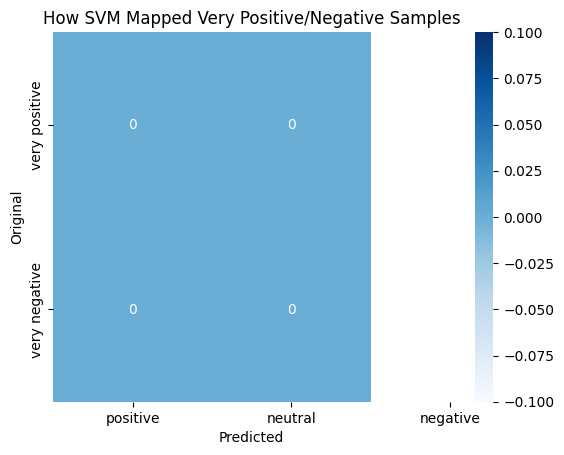

In [27]:
import pandas as pd

# Show original vs predicted mapping
result_df = pd.DataFrame({
    'Original': y_test_original.values,
    'Predicted': y_pred
})

print(result_df.value_counts())

# Optional: confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_original, y_pred, labels=['very positive', 'very negative'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['very positive', 'very negative'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Original')
plt.title('How SVM Mapped Very Positive/Negative Samples')
plt.show()


In [28]:
mask = df2['label'].isin(['very positive', 'very negative'])
test_indexes = df2[mask].index

# Step 2: Assign SVM predictions to those indexes
df2.loc[test_indexes, 'label'] = y_pred

In [29]:
df2['label'].value_counts()


,count
label,
positive,10331
negative,9437
neutral,8321


In [30]:
df2.to_csv("review 1 cleaned.csv", index=False)
